# Atelier : Prédiction floue du risque de panne d’une machine industrielle AFIFI SAAD IID3

**Objectifs**
- Construire un contrôleur flou pour estimer le risque de panne à partir de : température, vibration, âge.
- Générer 2000 échantillons synthétiques et calculer la sortie défuzzifiée (risque) par le modèle flou.
- Entraîner un modèle de régression (ML) sur ces données.
- Comparer la logique floue et le ML (MAE/MSE + discussion).

## Imports et univers
Nous importons les bibliothèques nécessaires et définissons les univers des variables :
- Température ∈ [0,100]
- Vibration ∈ [0,10]
- Âge ∈ [0,20]
- Risque ∈ [0,10]

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Univers
temp_univ = np.arange(0, 100.1, 0.5)
vib_univ  = np.arange(0, 10.01, 0.1)
age_univ  = np.arange(0, 20.01, 0.1)
risk_univ = np.arange(0, 10.01, 0.01)

## Déclaration des variables floues (Antecedents / Consequent)
On crée les Antecedents (Température, Vibration, Âge) et le Consequent (Risque).
Les noms des labels sont en anglais sans accents dans le code pour éviter des problèmes d'encodage.

In [38]:
# Variables floues
Temperature = ctrl.Antecedent(temp_univ, 'Temperature')
Vibration   = ctrl.Antecedent(vib_univ, 'Vibration')
Age         = ctrl.Antecedent(age_univ, 'Age')
Risk        = ctrl.Consequent(risk_univ, 'Risk')

## Fonctions d'appartenance (selon l'énoncé)

Température ∈ [0,100]
- basse  : [0,0,40]    -> trapézoïde / saturation à gauche
- normale: [30,50,70]  -> triangle
- élevée : [60,100,100] -> trapézoïde / saturation à droite

Vibration ∈ [0,10]
- faible : [0,0,4]
- moyenne: [2,5,8]
- forte  : [6,10,10]

Âge ∈ [0,20]
- neuf  : [0,0,7]
- moyen : [5,10,15]
- ancien: [12,20,20]

Risque ∈ [0,10]
- faible : [0,0,4]
- moyen  : [2,5,8]
- élevé  : [6,10,10]

In [39]:
# Temperature
Temperature['basse']   = fuzz.trapmf(Temperature.universe, [0, 0, 20, 40])   
Temperature['normale'] = fuzz.trimf(Temperature.universe, [30, 50, 70])
Temperature['elevee']  = fuzz.trapmf(Temperature.universe, [60, 80, 100, 100]) 

# Vibration
Vibration['faible']  = fuzz.trapmf(Vibration.universe, [0, 0, 1.5, 4])
Vibration['moyenne'] = fuzz.trimf(Vibration.universe, [2, 5, 8])
Vibration['forte']   = fuzz.trapmf(Vibration.universe, [6, 8, 10, 10])

# Age
Age['neuf']   = fuzz.trapmf(Age.universe, [0, 0, 3.5, 7])
Age['moyen']  = fuzz.trimf(Age.universe, [5, 10, 15])
Age['ancien'] = fuzz.trapmf(Age.universe, [12, 16, 20, 20])

# Risk (sortie)
Risk['faible'] = fuzz.trapmf(Risk.universe, [0, 0, 1.5, 4])
Risk['moyen']  = fuzz.trimf(Risk.universe, [2, 5, 8])
Risk['eleve']  = fuzz.trapmf(Risk.universe, [6, 8, 10, 10])

c:\Users\Asus VivoBook F1605P\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


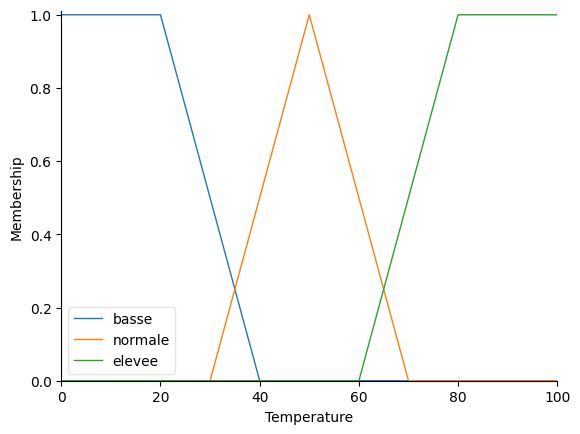

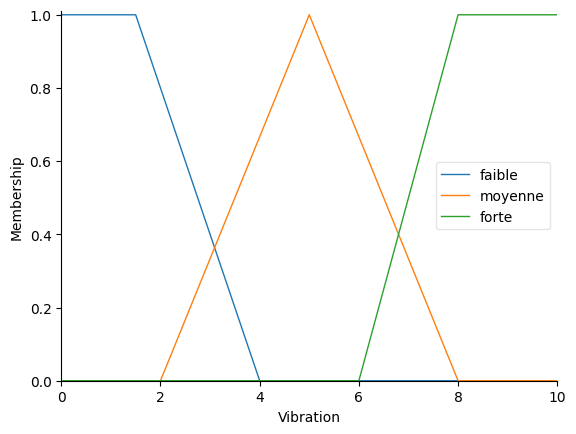

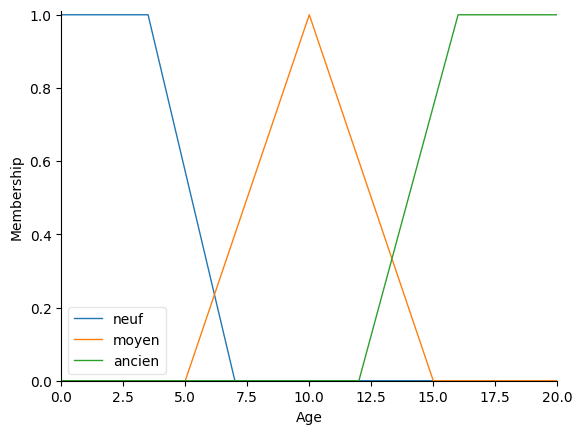

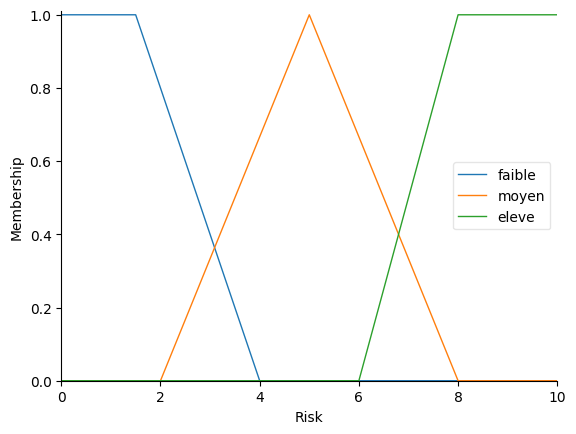

In [40]:
# Visualisation des MFs pour chaque variable
Temperature.view()
Vibration.view()
Age.view()
Risk.view()

## Règles d'inférence (raisonnement d'expert)

On encode les règles fournies par l'énoncé et quelques règles complémentaires raisonnables :
- Si température est élevée **OU** vibration est forte → risque élevé
- Si âge est ancien **ET** vibration est moyenne → risque moyen
- Si température est basse **ET** vibration faible **ET** âge neuf → risque faible
- Si température normale **ET** âge moyen → risque moyen

On ajoute aussi quelques règles pour compléter la couverture (optionnelles).

In [41]:
# Règles principales demandées
r1 = ctrl.Rule(Temperature['elevee'] | Vibration['forte'], Risk['eleve'])
r2 = ctrl.Rule(Age['ancien'] & Vibration['moyenne'], Risk['moyen'])
r3 = ctrl.Rule(Temperature['basse'] & Vibration['faible'] & Age['neuf'], Risk['faible'])
r4 = ctrl.Rule(Temperature['normale'] & Age['moyen'], Risk['moyen'])

# Règles complémentaires (pour meilleure couverture)
r5 = ctrl.Rule(Temperature['basse'] & Vibration['moyenne'], Risk['moyen'])
r6 = ctrl.Rule(Temperature['elevee'] & Age['ancien'], Risk['eleve'])
r7 = ctrl.Rule(Vibration['forte'] & Age['ancien'], Risk['eleve'])
r8 = ctrl.Rule(Temperature['normale'] & Vibration['faible'], Risk['faible'])

# Construire le système
risk_ctrl = ctrl.ControlSystem([r1,r2,r3,r4,r5,r6,r7,r8])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

## Test rapide : quelques simulations manuelles
On teste le contrôleur sur quelques triplets d'entrée pour vérifier la sortie.

In [42]:
tests = [
    (85, 7.5, 18),   # chaud, forte vib, ancien -> risque élevé attendu
    (25, 1.0, 2),    # basse temp, faible vib, neuf -> risque faible attendu
    (50, 5.0, 10),   # normale, moyenne vib, moyen age -> risque moyen attendu
    (70, 3.0, 5)     # elevee & vib modérée -> risque moyen/élevé
]

for T, V, A in tests:
    risk_sim.input['Temperature'] = T
    risk_sim.input['Vibration'] = V
    risk_sim.input['Age'] = A
    risk_sim.compute()
    print(f"T={T}, V={V}, Age={A} -> Risk(defuzz) = {risk_sim.output['Risk']:.3f}")

T=85, V=7.5, Age=18 -> Risk(defuzz) = 7.687
T=25, V=1.0, Age=2 -> Risk(defuzz) = 1.579
T=50, V=5.0, Age=10 -> Risk(defuzz) = 5.000
T=70, V=3.0, Age=5 -> Risk(defuzz) = 8.238


## Génération du dataset synthétique

- Générer 2000 échantillons aléatoires (uniformes) pour Température, Vibration, Âge.
- Pour chaque échantillon, calculer la valeur défuzzifiée du risque via le contrôleur flou.
- Stocker les triplets (T, V, Age) et la cible Risk dans un DataFrame.

In [43]:
N = 2000
np.random.seed(42)

temps = np.random.uniform(0, 100, N)
vibs  = np.random.uniform(0, 10, N)
ages  = np.random.uniform(0, 20, N)

risks = []
failed = 0

for T, V, A in zip(temps, vibs, ages):
    sim = ctrl.ControlSystemSimulation(risk_ctrl)
    sim.input['Temperature'] = float(T)
    sim.input['Vibration'] = float(V)
    sim.input['Age'] = float(A)
    try:
        sim.compute()
        r = sim.output.get('Risk', np.nan)
        risks.append(float(r) if r is not None else np.nan)
    except Exception:
        risks.append(np.nan)
        failed += 1

if failed:
    print(f"Warning: {failed} simulations failed and were filled with NaN.")

df = pd.DataFrame({
    'Temperature': temps,
    'Vibration': vibs,
    'Age': ages,
    'Risk_fuzzy': risks
})

df.head()

,Temperature,Vibration,Age,Risk_fuzzy
0,37.454012,2.617057,11.439918,3.727526
1,95.071431,2.469788,16.108647,7.722269
2,73.199394,9.062546,15.203219,8.444444
3,59.865848,2.495462,3.077998,1.703168
4,15.601864,2.719497,2.984989,3.108052


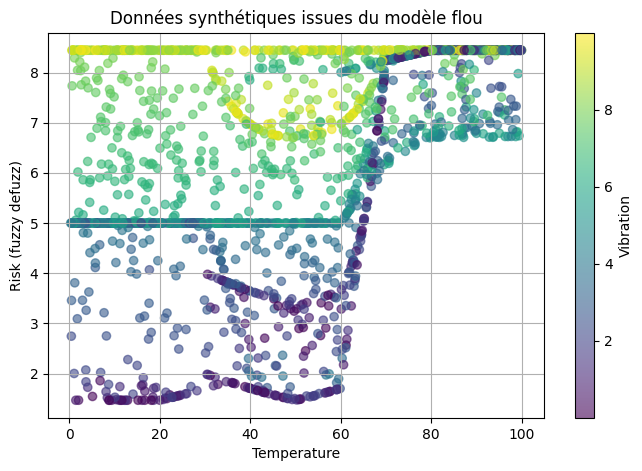

In [44]:

plt.figure(figsize=(8,5))
plt.scatter(df['Temperature'], df['Risk_fuzzy'], c=df['Vibration'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Vibration')
plt.xlabel('Temperature')
plt.ylabel('Risk (fuzzy defuzz)')
plt.title('Données synthétiques issues du modèle flou')
plt.grid(True)
plt.show()


## Entraînement ML

- Features : Temperature, Vibration, Age
- Cible : Risk_fuzzy
- Modèle : RandomForestRegressor (exemple robuste)
- Évaluation : séparation train/test, calcul MAE et MSE

In [45]:
df_clean = df.dropna(subset=['Risk_fuzzy']).reset_index(drop=True)
dropped = len(df) - len(df_clean)
if dropped:
	print(f"Dropped {dropped} samples with NaN target (Risk_fuzzy).")

X = df_clean[['Temperature','Vibration','Age']]
y = df_clean['Risk_fuzzy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE (Random Forest) = {mae:.4f}")
print(f"MSE (Random Forest) = {mse:.4f}")

Dropped 91 samples with NaN target (Risk_fuzzy).
MAE (Random Forest) = 0.0723
MSE (Random Forest) = 0.0427


## Comparaison

- Afficher quelques prédictions côte à côte (flou vs ML) sur l'échantillon de test.
- Visualiser la corrélation prédite vs réelle.

,Temperature,Vibration,Age,Risk_true,Risk_pred_ML
1633,61.958795,2.816160,13.131254,4.020421,4.018105
825,18.192813,7.587763,2.970136,7.629990,7.628393
1227,3.320311,9.017740,1.933891,8.444444,8.444444
240,38.509773,9.096268,1.240735,8.444444,7.989103
135,25.178230,5.407938,2.691525,5.000000,5.000000
1452,24.348230,0.710349,2.279318,1.563663,1.558399
536,2.878268,2.995657,13.581332,5.000000,5.000000
1477,96.292688,8.646589,12.521094,8.444444,8.314062
794,17.638699,2.888849,3.115465,3.402865,3.435214
77,86.310343,0.271674,13.847086,8.444444,8.400637


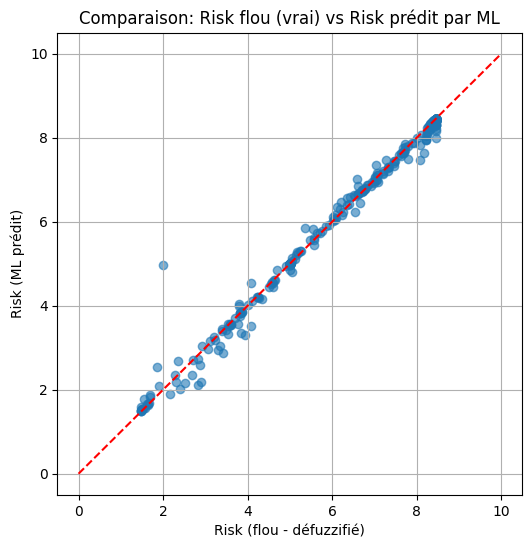

In [46]:
comp = X_test.copy()
comp['Risk_true'] = y_test
comp['Risk_pred_ML'] = y_pred

# Montrer quelques lignes
display(comp.head(10))

# Scatter plot comparaison
plt.figure(figsize=(6,6))
plt.scatter(comp['Risk_true'], comp['Risk_pred_ML'], alpha=0.6)
plt.plot([0,10],[0,10],'r--')  # y=x
plt.xlabel('Risk (flou - défuzzifié)')
plt.ylabel('Risk (ML prédit)')
plt.title('Comparaison: Risk flou (vrai) vs Risk prédit par ML')
plt.grid(True)
plt.show()

## Interprétation et comparaison

**Résultats métriques (exemple)** :
- MAE et MSE indiquent la capacité du modèle ML à reproduire la sortie du système flou.

**Avantages de la logique floue**
- **Explicabilité** : règles claires, compréhensibles par un expert (si T élevée OU vib forte -> risque élevé).
- **Robustesse aux incertitudes** : modélise l'imprécision des capteurs et du langage humain.
- **Nécessite peu de données** : s'appuie sur l'expertise plutôt que sur l'apprentissage massif.

**Avantages du Machine Learning**
- **Précision numérique** : peut généraliser et approximer précisément la surface de décision floue.
- **Automatisation** : une fois entraîné, exécute des prédictions très vite.
- **Flexibilité** : peut capter des interactions complexes si données et modèle adéquats.

**Remarque pédagogique**
- Ici le ML apprend la *sortie du système flou* (on a créé des labels à partir de la logique floue). Dans un cas réel on pourrait :
  - soit utiliser la logique floue comme "source d'étiquettes" pour créer rapidement un dataset,
  - soit entraîner le ML directement sur données réelles pour améliorer précision et détecter biais dans la modélisation floue.

In [47]:
df.to_csv('synthetic_machine_risk_dataset.csv', index=False)
print("Dataset sauvegardé : synthetic_machine_risk_dataset.csv")

Dataset sauvegardé : synthetic_machine_risk_dataset.csv
